In [1]:
#import necessary libraries
import glob
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.estimator import model_to_estimator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical
from numpy import std,array,argmax
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import statistics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import brier_score_loss


2022-04-20 13:22:27.119875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-20 13:22:27.119903: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def data_preparation_stacking():
    train_path='train'
    valid_path='test'
    folders=glob.glob("test/*") 

    train_no=len(os.listdir(train_path))



    train_datagen= ImageDataGenerator(rescale=1./255, 
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      rotation_range=30,
                                      width_shift_range=0.2,
                                     height_shift_range=0.2,

                                    )

    test_datagen= ImageDataGenerator(rescale=1./255)


    training_set= train_datagen.flow_from_directory( 'train',
                                                      target_size=(64,64),
                                                      batch_size=512,
                                                      color_mode='rgb',
                                                      class_mode='binary'


                                                    )
    test_set=test_datagen.flow_from_directory( 'test',
                                                target_size=(64,64),
                                                batch_size=512,
                                                color_mode='rgb',
                                                class_mode='binary' 
                                            )


    X_train,Y_train=next(training_set)
    X_test,Y_test=next(test_set)

    y_train=to_categorical(Y_train)
    y_test=to_categorical(Y_test)

    #for stacking
    X_train,x_new=X_train[:448,:,:,:],X_train[448:,:,:,:]
    y_Train,y_new=Y_train[:448],Y_train[448:]
    y_train,Y_new=y_train[:448],y_train[448:]
    
    
    return X_train,y_train,X_test,y_test,x_new,y_new,Y_test

In [3]:
def data_preparation_bagging():
    train_path='train'
    valid_path='test'
    folders=glob.glob("train/*") 

    train_no=len(os.listdir(train_path))



    train_datagen= ImageDataGenerator(rescale=1./255, 
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      rotation_range=30,
                                      width_shift_range=0.2,
                                     height_shift_range=0.2,

                                    )

    test_datagen= ImageDataGenerator(rescale=1./255)


    training_set= train_datagen.flow_from_directory( 'train',
                                                      target_size=(128,128),
                                                      batch_size=256,
                                                      color_mode='rgb',
                                                      class_mode='binary'


                                                    )
    test_set=test_datagen.flow_from_directory( 'test',
                                                target_size=(128,128),
                                                batch_size=256,
                                                color_mode='rgb',
                                                class_mode='binary' 
                                            )


    X_train,Y_train=next(training_set)
    X_test,Y_test=next(test_set)

    y_train=to_categorical(Y_train)
    y_test=to_categorical(Y_test)
    
    return X_train,y_train,X_test,y_test,Y_train,Y_test

In [4]:
def base_model_stacking():
    basemodel_resnet=ResNet50( include_top=False,
        weights="imagenet",
        input_shape=(64,64,3),
        classes=2)

    basemodel_efficientnet=EfficientNetB7( include_top=False,
        weights="imagenet",
        input_shape=(64,64,3),
        classes=2)

    basemodel_desnet=DenseNet121( include_top=False,
        weights="imagenet",
        input_shape=(64,64,3),
        classes=2)
    return basemodel_desnet,basemodel_resnet,basemodel_efficientnet

In [5]:
def  base_model_bagging():
    basemodel_resnet=ResNet50( include_top=False,
        weights="imagenet",
        input_shape=(128,128,3),
        classes=2)

    basemodel_efficientnet=EfficientNetB7( include_top=False,
        weights="imagenet",
        input_shape=(128,128,3),
        classes=2)

    basemodel_desnet=DenseNet121( include_top=False,
        weights="imagenet",
        input_shape=(128,128,3),
        classes=2)
    return basemodel_desnet,basemodel_resnet,basemodel_efficientnet

In [6]:
def report_plot(report,name=None):
    plt.figure(figsize=(10,10))
    x=list(report.keys())
    y=list(report.values())
    plt.bar(x,y)
    
def report_lineplot(report):
    plt.figure(figsize=(10,10))
    plt.title("Error_Graph")
    x=list(report.keys())
    y=list(report.values())
    plt.plot(x,y,c='r')
    

    

### Ensemble Bagging

In [7]:
def load_all_models_bagging(models):
    all_models = dict()
    for name in models:
        # Specify the filename
        filename = 'bagging/model_' + name + '.h5'
        # load the model 
        model = load_model(filename)
        # Add a list of all the weaker learners
        all_models[name]=model
        print('>loaded %s' % filename)
    return all_models

models_names=['Densenet121','Resnet50','EfficientnetB7']
# ensemble bagging split samples with replacement and train each model
def ensemble_bagging(X_train,Y_train,X_test,Y_test,models_lst,n_folds,basemodel_densenet,basemodel_resnet,basemodel_efficientnet,training=None):
    if training==True:
        # split samples with replacement
        X_train_List=[]
        Y_train_List=[]
        for i in range(len(models_lst)):
            indices=np.random.choice(X_train.shape[0],X_train.shape[0]//n_folds,replace=True)
            X_train_samples=X_train[indices]
            Y_train_samples=Y_train[indices]
            X_train_List.append(X_train_samples)
            Y_train_List.append(Y_train_samples)
        # train each model
        n_models=len(models_lst)
        models={}
        result={}
        for i in range(n_models):
            model_name=models_lst[i]
            print(f"training model {model_name}")
            model=Sequential()
            if model_name=='Densenet121':
                model.add(basemodel_densenet)
            if model_name=='Resnet50':
                model.add(basemodel_resnet)
            if model_name=='EfficientnetB7':
                model.add(basemodel_efficientnet)

            model.add(Flatten())
            model.add(Dense(64,activation=('relu')))
            # model.add(Dropout(0.3))
            # model.add(Dense(64,activation='relu'))
            model.add(Dense(2,activation='sigmoid'))
            model.compile(loss='binary_crossentropy',
                          optimizer=SGD(learning_rate=0.001),
                          metrics=['accuracy'])
            model.fit(X_train_List[i],Y_train_List[i],epochs=5,verbose=1)
            if not 'bagging' in os.listdir():
                os.mkdir('bagging')
            model.save(f'bagging/model_{model_name}.h5')

            
        
            _,test_acc=model.evaluate(X_test,Y_test,verbose=1)
            models[model_name]=model
            result[f'{model_name}_accuracy']=test_acc
        
        
    else:
        result={}
        models=load_all_models_bagging(models_lst)
        for name,model in models.items():
            _,test_acc=model.evaluate(X_test,Y_test,verbose=1)
            result[f'{name}_accuracy']=test_acc
    return models,result


def bagging_voting(X_train,Y_train,X_test,Y_test,y_test,models_names,n_folds,basemodel_densenet,basemodel_resnet,basemodel_efficientnet,training):
    models,final_result=ensemble_bagging(X_train,Y_train,X_test,Y_test,models_names,n_folds,basemodel_densenet,basemodel_resnet,basemodel_efficientnet,training)
    result=[]
    model_loss={}
    for name,model in models.items():
        pred=model.predict(X_test)
        prediction=np.argmax(pred,axis=1)
        loss=brier_score_loss(y_test,prediction)
        model_loss[f'{name}_loss']=loss
        
        result.append(prediction)
    
    final_prediction=[]
    for i in range(len(result[0])):
        lst=[]
        lst.append(result[0][i])
        lst.append(result[1][i])
        lst.append(result[2][i])
        final_prediction.append(statistics.mode(lst))
        
     
    return final_prediction,final_result,result,model_loss

def bagging_classification_report(models_pred,y_test,bagging_pred):
    precision_report={}    
    recall_report={}
    f1_score_report={}

    classification_report_densenet=precision_recall_fscore_support(y_test,models_pred[0],average='weighted')
    classification_report_resnet=precision_recall_fscore_support(y_test,models_pred[1],average='weighted')
    classification_report_efficientnet=precision_recall_fscore_support(y_test,models_pred[2],average='weighted')
    classification_report_bagging=precision_recall_fscore_support(y_test,bagging_pred,average='weighted')

    precision_report['densenet_precision']=classification_report_densenet[0]
    precision_report['resnet_precision']=classification_report_resnet[0]
    precision_report['efficientnet_precision']=classification_report_efficientnet[0]
    precision_report['bagging_precision']=classification_report_bagging[0]

    recall_report['densenet_recall']=classification_report_densenet[1]
    recall_report['resnet_recall']=classification_report_resnet[1]
    recall_report['effiecientnet_recall']=classification_report_efficientnet[1]
    recall_report['bagging_recall']=classification_report_bagging[1]

    f1_score_report['densenet_f1score']=classification_report_densenet[2]
    f1_score_report['resnet_f1score']=classification_report_resnet[2]
    f1_score_report['efficientnet_f1score']=classification_report_efficientnet[2]
    f1_score_report['bagging_f1score']=classification_report_bagging[2]

    return precision_report,recall_report,f1_score_report



In [8]:
def bagging_main():
    models_names=['Densenet121','Resnet50','EfficientnetB7']
    basemodel_densenet,basemodel_resnet,basemodel_efficientnet=base_model_bagging()
    X_train,y_train,X_test,y_test,Y_train,Y_test=data_preparation_bagging()
    final_prediction,accuracy_report,models_pred,loss_report=bagging_voting(X_train,y_train,X_test,y_test,Y_test,models_names,3,basemodel_densenet,basemodel_resnet,basemodel_efficientnet,training=True)
    bagging_accuracy_score=accuracy_score(Y_test,final_prediction)
    bagging_loss_score=brier_score_loss(Y_test,final_prediction)
    accuracy_report['bagging_accuracy']=bagging_accuracy_score
    loss_report['bagging_loss']=bagging_loss_score
    precision_report,recall_report,f1_score_report=bagging_classification_report(models_pred,Y_test,final_prediction)
    
    
    print("\n")
    report_plot(accuracy_report)
    report_lineplot(loss_report)
    report_plot(precision_report)
    report_plot(recall_report)
    report_plot(f1_score_report)
    
    


### Ensemble Stacking

In [9]:
# evaluate a single mlp model
def get_model_trained(X_train,y_train,X_test,y_test,base_model,name=None):
    # define model
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    if name=='densenet':
        model.add(Dense(128,activation=('relu')))
    elif name=='resnet':
        model.add(Dense(16,activation=('relu')))
    elif name=='efficientnet':
        model.add(Dense(32,activation=('relu')))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])
    # fit model
    model.fit(X_train, y_train, epochs=5, verbose=1)
    # evaluate the model
    _, test_acc = model.evaluate(X_test, y_test, verbose=1)
    return model, test_acc

def load_all_models(models):
    all_models = list()
    for name in models:
        # Specify the filename
        filename = 'stacking/model_' + name + '.h5'
        # load the model 
        model = load_model(filename)
        # Add a list of all the weaker learners
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


# create stacked model input dataset as outputs from the ensemble
def create_stacked_dataset(members, X_test):
    stackX=None
    for model in members:
        #make predictions
        y_pred=model.predict(X_test)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX=y_pred
        else:
            stackX=np.dstack((stackX,y_pred))

    # flatten predictions to [rows, members * probabilities]
    stackX=stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX


# fit meta model based on the outputs from the ensemble members
def fit_stacked_model(members, X_test,y_train):
    # create dataset using ensemble
    stackedX=create_stacked_dataset(members, X_test)

    # fit the SVM meta midel
    meta_model=SVC()
    meta_model.fit(stackedX,y_train)
    return meta_model

# make a prediction with the stacked model
def stacked_predict(members, X_test, meta_model):
    # create dataset using ensemble
    stackedX=create_stacked_dataset(members, X_test)
    # predict with the stacked model
    return meta_model.predict(stackedX)


def stacking_ensemble(X_train,y_train,X_test,y_test,x_new,y_new,Y_test,basemodel_desnet,basemodel_resnet,basemodel_efficientnet, models_training=True):
    models=['densenet','resnet','efficientnet']  
    if models_training==True:
        print("Starting.....")
        print("Training Densenet121")
        model_densenet,testacc_densenet=get_model_trained(X_train,y_train,X_test,y_test,basemodel_desnet,name='densenet')
        print("Training Resnet50")
        model_resnet,testacc_resnet=get_model_trained(X_train,y_train,X_test,y_test,basemodel_resnet,name='resnet')
        print("Training EfficientnetB7")
        model_efficientnet,testacc_efficientnet=get_model_trained(X_train,y_train,X_test,y_test,basemodel_efficientnet,name='efficientnet')

        if not 'stacking' in os.listdir():
            os.mkdir('stacking')
        else:
            pass

        model_densenet.save('stacking/model_densenet.h5')
        model_resnet.save('stacking/model_resnet.h5')
        model_efficientnet.save('stacking/model_efficientnet.h5')
 

        members=load_all_models(models)
        print('Loaded %d models' % len(members))
    
    else:
        members=load_all_models(models)
        print('Loaded %d models' % len(members))
        for i in range(len(models)):
            if models[i]=='densenet':
                _,testacc_densenet=members[i].evaluate(X_test,y_test,verbose=0)
            if models[i]=='resnet':
                _,testacc_resnet=members[i].evaluate(X_test,y_test,verbose=0)
            if models[i]=='efficientnet':
                _,testacc_efficientnet=members[i].evaluate(X_test,y_test,verbose=0)


            
        

    meta_model=fit_stacked_model(members,x_new,y_new)
    
    models_pred={}
    loss={}
    for i in range(len(models)):
        pred=members[i].predict(X_test)
        pred=np.argmax(pred,axis=1)
        loss[f'{models[i]}_loss']=brier_score_loss(Y_test,pred)
        models_pred[models[i]]=pred

    meta_model_pred=stacked_predict(members, X_test, meta_model)
    meta_model_loss=brier_score_loss(Y_test,meta_model_pred)
    loss['stacked_meta_loss']=meta_model_loss

    accuracy_dict={'densenet_accuracy':testacc_densenet,'resnet_accuracy':testacc_resnet,'efficientnet_accuracy':testacc_efficientnet,'stacked_meta_accuracy':accuracy_score(Y_test,meta_model_pred)}
    return accuracy_dict, meta_model_pred,models_pred,loss

In [10]:
def classification_report(models_pred,y_test,meta_model_pred):
    precision_report={}    
    recall_report={}
    f1_score_report={}
    
    classification_report_densenet=precision_recall_fscore_support(y_test,models_pred['densenet'],average='weighted')
    classification_report_resnet=precision_recall_fscore_support(y_test,models_pred['resnet'],average='weighted')
    classification_report_efficientnet=precision_recall_fscore_support(y_test,models_pred['efficientnet'],average='weighted')
    classification_report_stacking=precision_recall_fscore_support(y_test,meta_model_pred,average='weighted')
    
    precision_report['densenet_precision']=classification_report_densenet[0]
    precision_report['resnet_precision']=classification_report_resnet[0]
    precision_report['efficientnet_precision']=classification_report_efficientnet[0]
    precision_report['stacked_meta_precision']=classification_report_stacking[0]
    
    recall_report['densenet_recall']=classification_report_densenet[1]
    recall_report['resnet_recall']=classification_report_resnet[1]
    recall_report['effiecientnet_recall']=classification_report_efficientnet[1]
    recall_report['stacked_meta_recall']=classification_report_stacking[1]
    
    f1_score_report['densenet_f1score']=classification_report_densenet[2]
    f1_score_report['resnet_f1score']=classification_report_resnet[2]
    f1_score_report['efficientnet_f1score']=classification_report_efficientnet[2]
    f1_score_report['stacked_meta_f1score']=classification_report_stacking[2]
    
    return precision_report,recall_report,f1_score_report


In [11]:
def stacking_main():
    X_train,y_train,X_test,y_test,x_new,y_new,Y_test=data_preparation_stacking()
    basemodel_densenet,basemodel_resnet,basemodel_efficientnet=base_model_stacking()
    accuracy_report,meta_model_pred,models_pred,loss_report=stacking_ensemble(X_train,y_train,X_test,y_test,x_new,y_new,Y_test,basemodel_densenet,basemodel_resnet,basemodel_efficientnet,
                                                                              models_training=True)
    precision_report,recall_report,f1_score_report=classification_report(models_pred,Y_test,meta_model_pred)
    
    
    print("\n")
    report_plot(accuracy_report)
    report_lineplot(loss_report)
    report_plot(precision_report)
    report_plot(recall_report)
    report_plot(f1_score_report)

In [14]:
def ensemble_method_main():
    print("*************************************** ENSEMBLE BAGGING *************************************************")
    print("\n")
    bagging_main()
    print("\n")
    
    print("*************************************** ENSEMBLE STACKING ********************************************")
    stacking_main()
    
    print("--------------------------Bagging and Stacking Report Analysis-------------------------------------------")

    
    

*************************************** ENSEMBLE BAGGING ********************************************




2022-04-20 13:22:34.975441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-20 13:22:34.975482: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 13:22:34.975507: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-04-20 13:22:34.975724: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 6244 images belonging to 2 classes.
Found 1562 images belonging to 2 classes.
training model Densenet121
Epoch 1/5
3/3 [==============================] - 19s 3s/step - loss: 0.7672 - accuracy: 0.5647
Epoch 2/5
3/3 [==============================] - 10s 3s/step - loss: 0.5796 - accuracy: 0.7059
Epoch 3/5
3/3 [==============================] - 10s 3s/step - loss: 0.4594 - accuracy: 0.8471
Epoch 4/5
3/3 [==============================] - 9s 3s/step - loss: 0.3523 - accuracy: 0.9294
Epoch 5/5
8/8 [==============================] - 6s 558ms/step - loss: 0.9336 - accuracy: 0.5000
training model Resnet50
Epoch 1/5
3/3 [==============================] - 17s 3s/step - loss: 0.8181 - accuracy: 0.5059
Epoch 2/5
3/3 [==============================] - 10s 3s/step - loss: 0.5638 - accuracy: 0.7529
Epoch 3/5
3/3 [==============================] - 10s 3s/step - loss: 0.3271 - accuracy: 0.9059
Epoch 4/5
3/3 [==============================] - 10s 3s/step - loss: 0.2152 - accuracy: 0.9647
Epoch 5/5

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,





*************************************** ENSEMBLE STACKING ********************************************
Found 6244 images belonging to 2 classes.
Found 1562 images belonging to 2 classes.
Starting.....
Training Densenet121
Epoch 1/5
14/14 [==============================] - 23s 961ms/step - loss: 0.9176 - accuracy: 0.4978
Epoch 2/5
14/14 [==============================] - 13s 956ms/step - loss: 0.7533 - accuracy: 0.5938
Epoch 3/5
14/14 [==============================] - 14s 966ms/step - loss: 0.6517 - accuracy: 0.6987
Epoch 4/5
14/14 [==============================] - 13s 954ms/step - loss: 0.6035 - accuracy: 0.7321
Epoch 5/5
16/16 [==============================] - 5s 179ms/step - loss: 0.8754 - accuracy: 0.5781
Training Resnet50
Epoch 1/5
14/14 [==============================] - 34s 2s/step - loss: 0.8741 - accuracy: 0.4821
Epoch 2/5
14/14 [==============================] - 29s 2s/step - loss: 0.7474 - accuracy: 0.5670
Epoch 3/5
14/14 [==============================] - 28s 2s/step 

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




--------------------------Bagging and Stacking Report Analysis-------------------------------------------


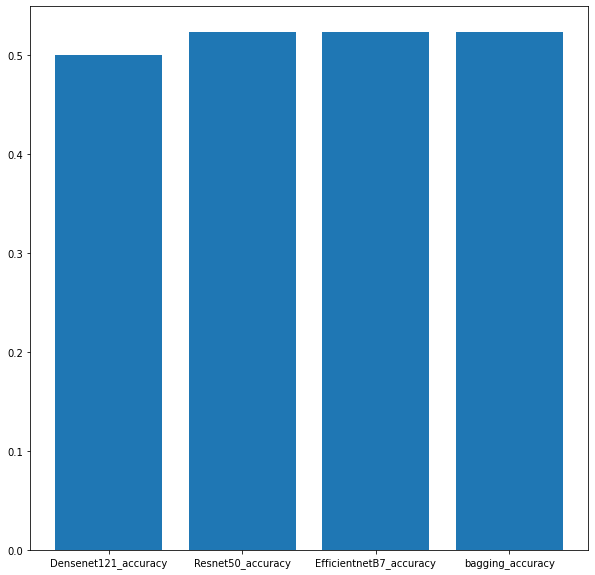

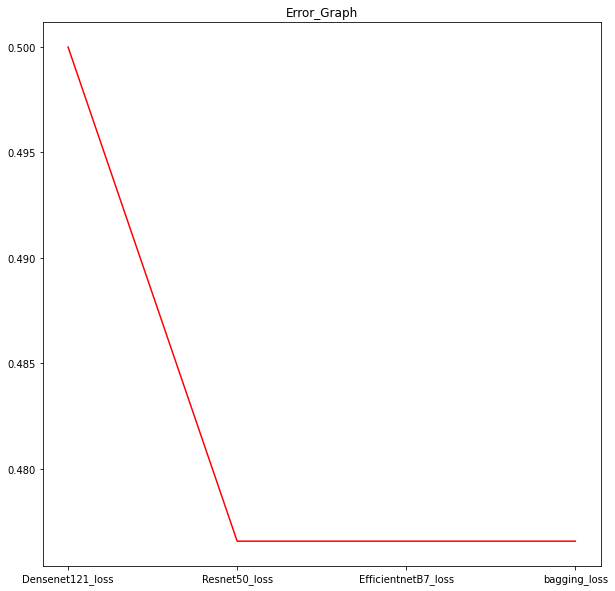

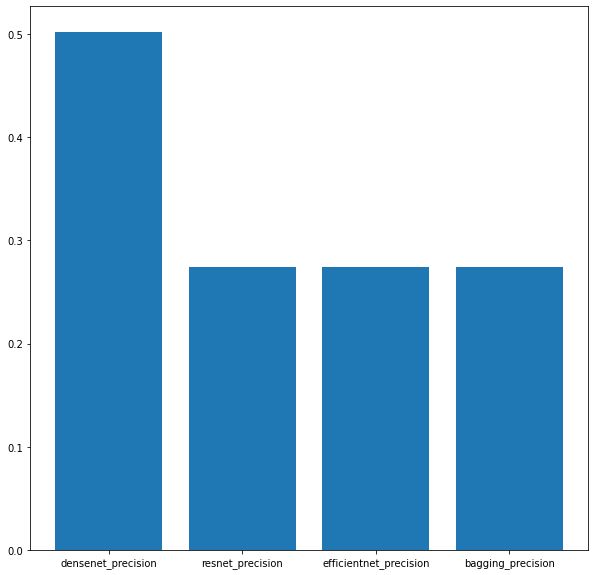

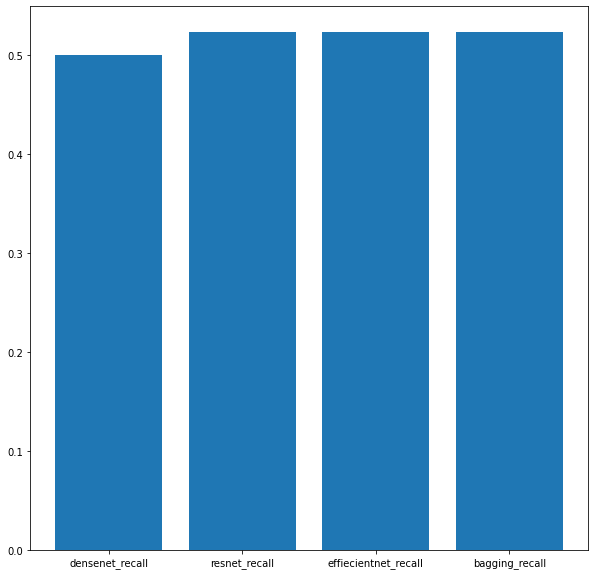

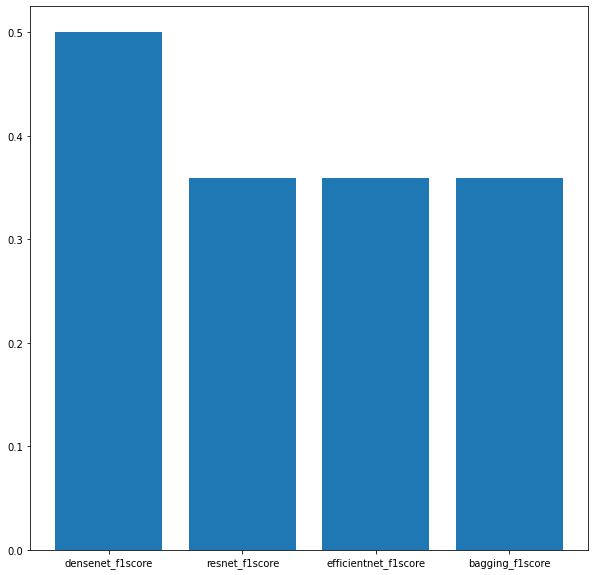

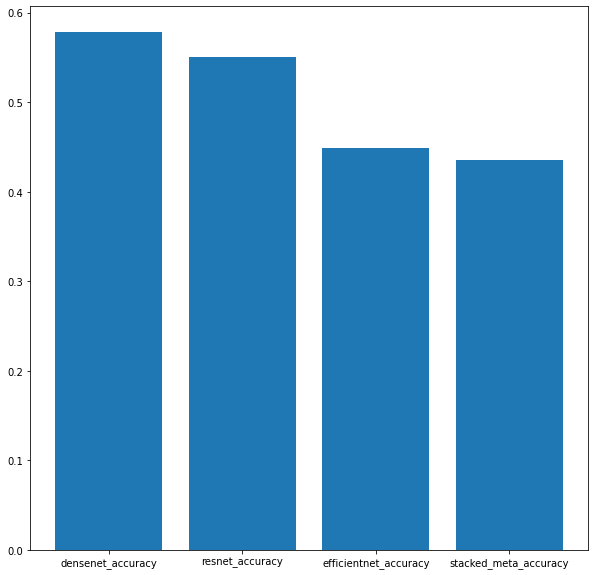

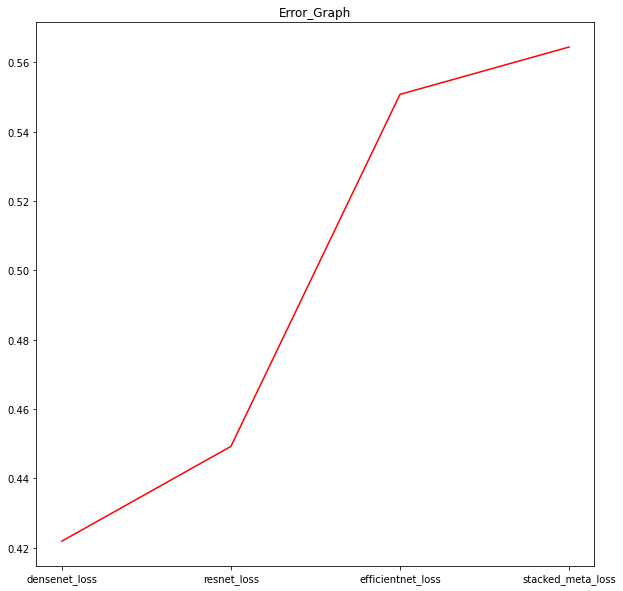

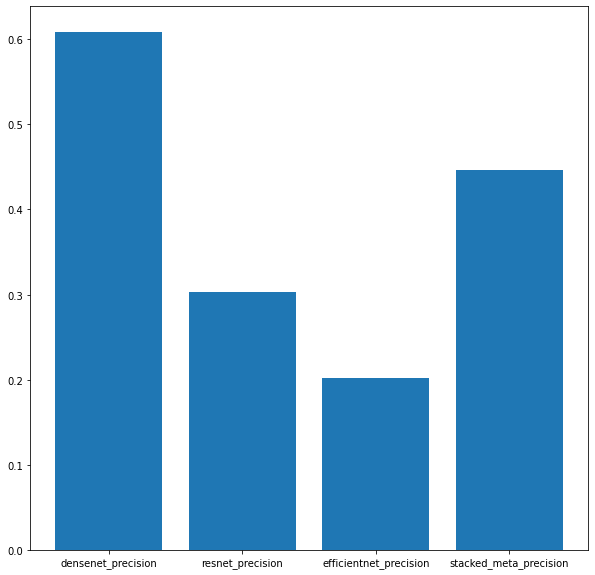

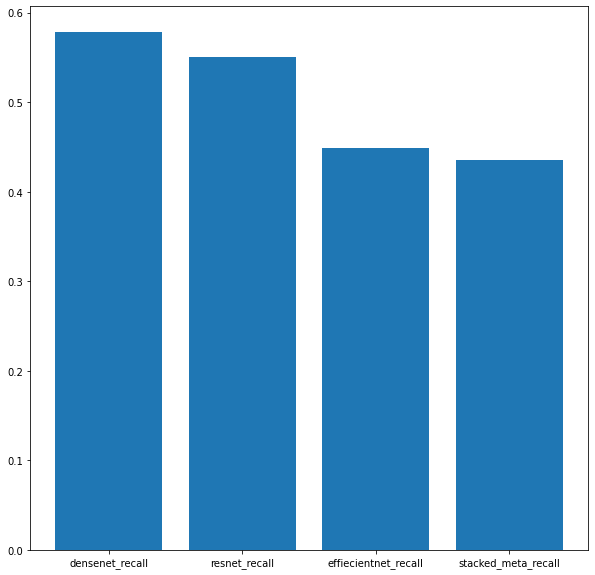

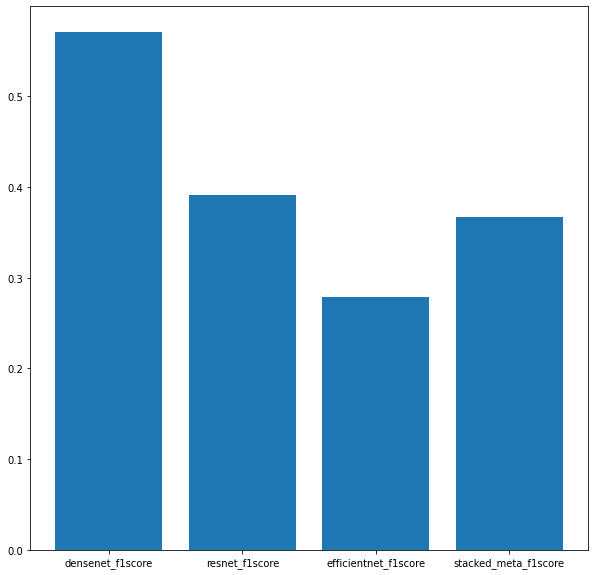

In [13]:
ensemble_method_main()

##### 